In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import sklearn
import seaborn as sns
import numpy as np

In [3]:
# Import the dataset
df = pd.read_csv('/users/crazyworld/desktop/MLpython/lab2/fe/fer2013/fer2013.csv')
h = 48
w = 48
display(df.shape)
df.head(5)

(35887, 3)

emotion                                             pixels     Usage
0        0  70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...  Training
1        0  151 150 147 155 148 133 111 140 170 174 182 15...  Training
2        2  231 212 156 164 174 138 161 173 182 200 106 38...  Training
3        4  24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...  Training
4        6  4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...  Training

In [4]:
#names = df.emotion
#names = names.replace(0,'Angry')
#names = names.replace(1,'Disgust')
#names = names.replace(2,'Fear')
#names = names.replace(3,'Happy')
#names = names.replace(4,'Sad')
#names = names.replace(5,'Surprise')
#names = names.replace(6,'Neutral')

In [5]:
dfr = df.sample(n=1000, random_state=0)
dfr = dfr.reset_index(drop=True)
df1 = dfr.copy()
names = df1.emotion
for i in range(len(df1.pixels)):
    df1.pixels[i] = np.array(list(map(int,df1.pixels[i].split(' '))))
names = names.replace(0,'Angry')
names = names.replace(1,'Disgust')
names = names.replace(2,'Fear')
names = names.replace(3,'Happy')
names = names.replace(4,'Sad')
names = names.replace(5,'Surprise')
names = names.replace(6,'Neutral')

/anaconda3/envs/mlenv/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


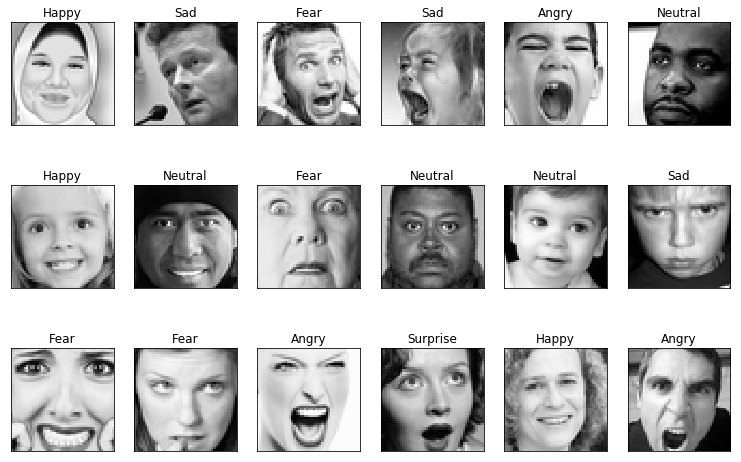

In [6]:
# a helper plotting function
def plot_gallery(images, titles, h, w, n_row=3, n_col=6):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.7 * n_col, 2.3 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

plot_gallery(df1.pixels, names, h, w) # defaults to showing a 3 by 6 subset of the faces

In [7]:
# manipulated from Sebastian Raschka Example (your book!)
# also from hi blog here: http://sebastianraschka.com/Articles/2015_pca_in_3_steps.html
from sklearn.decomposition import PCA
#dfr = dfr.drop("emotion",axis=1)
#X = dfr.values
X = np.array([i for i in df1.pixels])
X = X.astype(float)
def plot_explained_variance(pca):
    import plotly
    from plotly.graph_objs import Bar, Line
    from plotly.graph_objs import Scatter, Layout
    from plotly.graph_objs.scatter import Marker
    from plotly.graph_objs.layout import XAxis, YAxis
    plotly.offline.init_notebook_mode() # run at the start of every notebook
    
    explained_var = pca.explained_variance_ratio_
    cum_var_exp = np.cumsum(explained_var)
    
    plotly.offline.iplot({
        "data": [Bar(y=explained_var, name='individual explained variance'),
                 Scatter(y=cum_var_exp, name='cumulative explained variance')
            ],
        "layout": Layout(xaxis=XAxis(title='Principal components'), yaxis=YAxis(title='Explained variance ratio'))
    })
        

In [8]:
# lets do some PCA of the features and go from 1850 features to 20 features
from sklearn.decomposition import PCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces" % (
    n_components, X.shape[0]))

pca = PCA(n_components=n_components)
%time pca.fit(X.copy())
eigenfaces = pca.components_.reshape((n_components, h, w))

Extracting the top 300 eigenfaces from 1000 faces
CPU times: user 1.08 s, sys: 57 ms, total: 1.14 s
Wall time: 296 ms


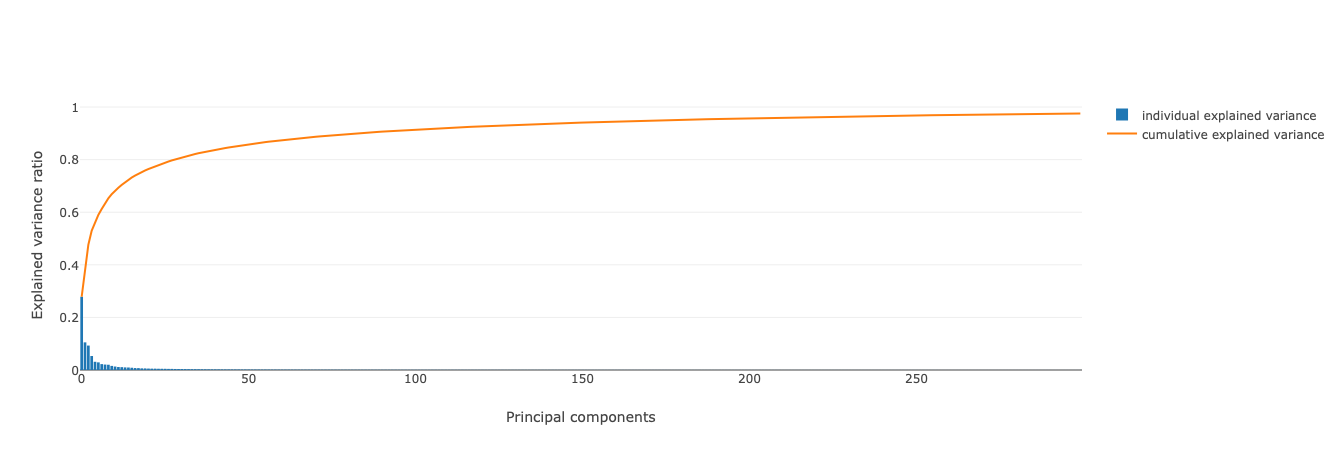

In [53]:
plot_explained_variance(pca)

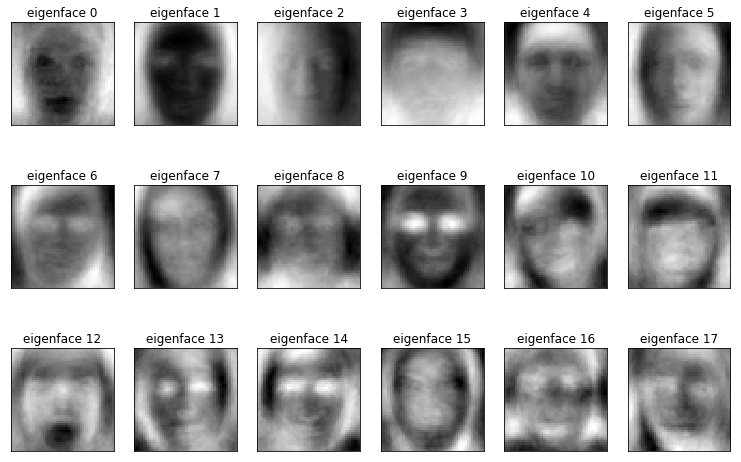

In [203]:
eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [9]:
def reconstruct_image(trans_obj,org_features):
    low_rep = trans_obj.transform(org_features)
    rec_image = trans_obj.inverse_transform(low_rep)
    return low_rep, rec_image
    
idx_to_reconstruct = 39
X_idx = X[idx_to_reconstruct]
low_dimensional_representation, reconstructed_image = reconstruct_image(pca,X_idx.reshape(1, -1))

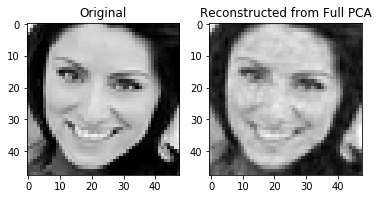

In [10]:
image0 = X_idx.reshape((h, w))
plt.subplot(1,2,1)
plt.imshow(image0, cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
image1 = reconstructed_image.reshape((h, w))
plt.subplot(1,2,2)
plt.imshow(image1, cmap=plt.cm.gray)
plt.title('Reconstructed from Full PCA')
plt.grid(False)

In [11]:
%%time
#  THIS  TAKES A LONG TIME TO RUN
from sklearn.decomposition import KernelPCA

n_components = 300
print ("Extracting the top %d eigenfaces from %d faces, ALSO getting inverse transform" % (n_components, X.shape[0]))

kpca = KernelPCA(n_components=n_components, kernel='rbf', 
                fit_inverse_transform=True, gamma=12, # very sensitive to the gamma parameter,
                remove_zero_eig=True)  
kpca.fit(X.copy())


Extracting the top 300 eigenfaces from 1000 faces, ALSO getting inverse transform
CPU times: user 850 ms, sys: 28.1 ms, total: 879 ms
Wall time: 227 ms


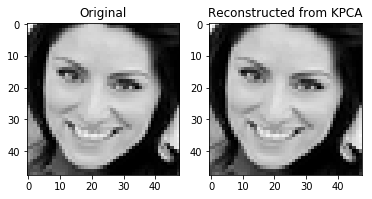

In [12]:
low_dimensional_representation, reconstructed_image_kpca = reconstruct_image(kpca, X_idx.reshape(1, -1))

plt.subplot(1,2,1)
plt.imshow(image0, cmap=plt.cm.gray)
plt.title('Original')
plt.grid(False)
image2 = reconstructed_image_kpca.reshape((h, w))
plt.subplot(1,2,2)
plt.imshow(image2, cmap=plt.cm.gray)
plt.title('Reconstructed from KPCA')
plt.grid(False)

In [13]:
# import the necessary packages
from skimage.measure import compare_ssim as ssim
import matplotlib.pyplot as plt
import numpy as np
def BrigthnessNormalization(img):
    r = img / np.sqrt( np.sum((img**2), 0) )
    return r
image0 = BrigthnessNormalization(image0)
image1 = BrigthnessNormalization(image1)
image2 = BrigthnessNormalization(image2)
s1 = ssim(image0,image1)
s2 = ssim(image0,image2)
s3 = ssim(image1,image2)
print(s1)
print(s2)
print(s3)

0.9848092319280812
0.9999841658158212
0.9848374490293345


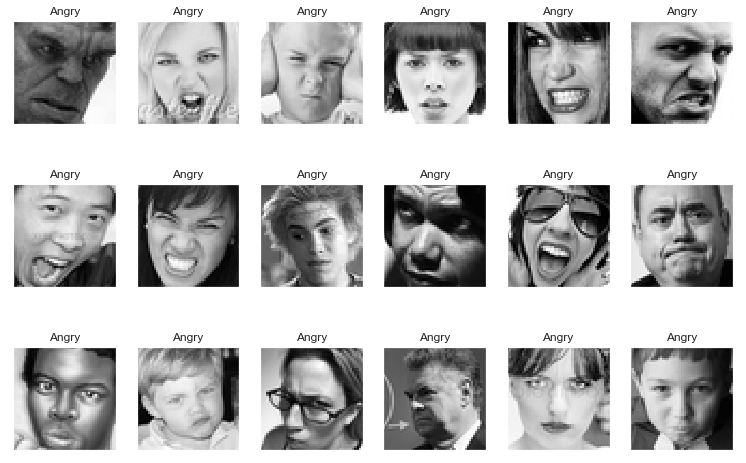

In [109]:
df2 = df1.sort_values(by=['emotion'])
df2 = df2.reset_index(drop=True)
X = np.array([i for i in df2.pixels])
X = X.astype(float)
namess = df2.emotion
namess = namess.replace(0,'Angry')
namess = namess.replace(1,'Disgust')
namess = namess.replace(2,'Fear')
namess = namess.replace(3,'Happy')
namess = namess.replace(4,'Sad')
namess = namess.replace(5,'Surprise')
namess = namess.replace(6,'Neutral')
plot_gallery(df2.pixels, namess, h, w) # defaults to showing a 3 by 6 subset of the faces

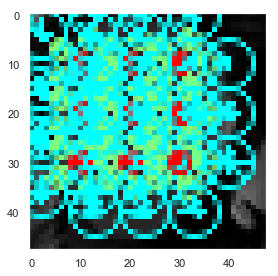

In [85]:
from skimage.feature import daisy
from skimage.io import imshow
# lets first visualize what the daisy descripto looks like
features, img_desc = daisy(image0,step=10, radius=10, rings=2, histograms=5, orientations=8, visualize=True)
imshow(img_desc)
plt.grid()

In [47]:
# now let's understand how to use it
features = daisy(image0,step=10, radius=10, rings=2, histograms=5, orientations=8, visualize=False)
print(features.shape)
print(features.shape[0]*features.shape[1]*features.shape[2])

(3, 3, 88)
792


In [111]:
# create a function to tak in the row of the matric and return a new feature
def apply_daisy(row,shape):
    feat = daisy(row.reshape(shape),step=10, radius=10, rings=2, histograms=5, orientations=8, visualize=False)
    return feat.reshape((-1))

%time test_feature = apply_daisy(X[39],(h,w))
test_feature.shape

CPU times: user 12 ms, sys: 2.06 ms, total: 14.1 ms
Wall time: 12.1 ms


(792,)

In [112]:
# apply to entire data, row by row,
# takes about a minute to run
%time daisy_features = np.apply_along_axis(apply_daisy, 1, X, (h,w))
print(daisy_features.shape)

CPU times: user 5.59 s, sys: 22.2 ms, total: 5.62 s
Wall time: 5.63 s
(1000, 792)


In [69]:
print(daisy_features[0].shape)

(792,)


In [113]:
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.preprocessing import StandardScaler

std = StandardScaler()
#dist_matrix = pairwise_distances(daisy_features)
dist_matrix = pairwise_distances(std.fit_transform(daisy_features))
print(dist_matrix.shape)

(1000, 1000)


/anaconda3/envs/mlenv/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "
/anaconda3/envs/mlenv/lib/python3.7/site-packages/skimage/io/_plugins/matplotlib_plugin.py:80: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  warn("Float image out of standard range; displaying "


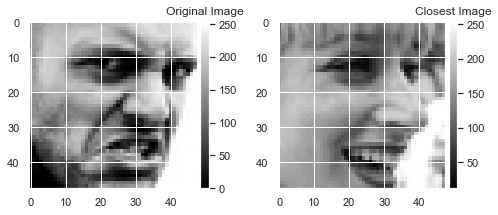

In [73]:
import copy
# find closest image to current image
idx1 = 5
distances = copy.deepcopy(dist_matrix[idx1,:])
distances[idx1] = np.infty # dont pick the same image!
idx2 = np.argmin(distances)

plt.figure(figsize=(7,10))
plt.subplot(1,2,1)
imshow(X[idx1].reshape((h,w)),cmap=plt.cm.gray)
plt.title("Original Image")
plt.grid()

plt.subplot(1,2,2)
imshow(X[idx2].reshape((h,w)),cmap=plt.cm.gray)
plt.title("Closest Image")
plt.grid()

In [74]:
from ipywidgets import widgets  # make this interactive!
from ipywidgets import fixed
n_samples, n_features = X.shape
y = df1.emotion
# put it together inside a nice widget
def closest_image(dmat,idx1):
    distances = copy.deepcopy(dmat[idx1,:]) # get all image diatances
    distances[idx1] = np.infty # dont pick the same image!
    idx2 = np.argmin(distances)
    
    distances[idx2] = np.infty
    idx3 = np.argmin(distances)
    
    plt.figure(figsize=(10,16))
    plt.subplot(1,3,1)
    imshow(X[idx1].reshape((h,w)),cmap=plt.cm.gray)
    plt.title("Original Image "+names[idx1])
    plt.grid()

    plt.subplot(1,3,2)
    imshow(X[idx2].reshape((h,w)),cmap=plt.cm.gray)
    plt.title("Closest Image  "+names[idx2])
    plt.grid()
    
    plt.subplot(1,3,3)
    imshow(X[idx3].reshape((h,w)),cmap=plt.cm.gray)
    plt.title("Next Closest Image "+names[idx3])
    plt.grid()
    
widgets.interact(closest_image,idx1=(0,n_samples-1,1),dmat=fixed(dist_matrix),__manual=True)

interactive(children=(IntSlider(value=499, description='idx1', max=999), Output()), _dom_classes=('widget-inte…

<function __main__.closest_image(dmat, idx1)>

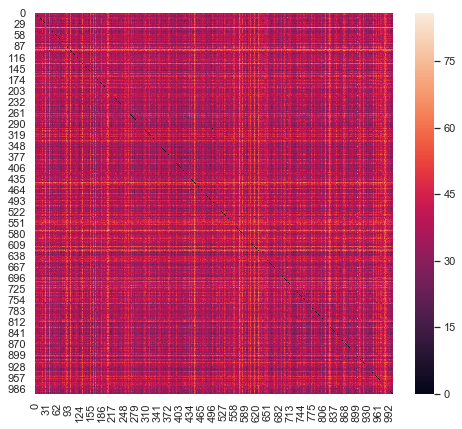

In [114]:
import seaborn as sns
cmap = sns.set(style="darkgrid") # one of the many styles to plot using
f, ax = plt.subplots(figsize=(8, 7))
sns.heatmap(dist_matrix, cmap=cmap, annot=False)

In [143]:
banana = np.array([1,2,3,4,5.5])
apple=banana.astype(int)
banana

array([1. , 2. , 3. , 4. , 5.5])